# Regresion logistica
La documentacion sobre el modelo la obtenemos de:  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns

from preprocessing import cargarDatasets
from preprocessing import prepararSet
from preprocessing import ingenieriaDeFeaturesVariablesNormalizadas
from preprocessing import ingenieriaDeFeauturesVariablesNormalizadasME

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV

## Carga y preprocesamiento de los datos

Cargamos los datasets y preparamos los datos para entrenar la regresion.

In [18]:
train_df,final_df = cargarDatasets()
train_df = prepararSet(train_df)

In [19]:
X,y,df,y_encoder = ingenieriaDeFeaturesVariablesNormalizadas(train_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y)

X_2,y_2,df_2,y_encoder_2,meanEncoding = ingenieriaDeFeauturesVariablesNormalizadasME(train_df)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state=117, test_size=0.1, stratify=y_2)

Queremos encontrar los mejores hiperparametros para la regresion. Con estos hiperparametros buscamos minimizar el error en las predicciones, construyendo un modelo robusto y regularizado, para que logre generalizar para datos futuros.

Parametros:
* C: que tanto regularizamos. Similar al C de SVM, cuanto mas pequeño este valor mas fuerte sera la regularizacion.  
* penalty: tipo de regularizacion, estas pueden ser l1 (lasso), l2 (ridge) o elastic net.


In [20]:
params = [
    {'penalty' : ['l1','l2','elasticnet'],
     'C' : [0.001,0.005,0.01,0.05,0.1,0.3,1,3,5,10,30,50,55,75,100,120,150,],   
    }]

In [21]:
regresion1 = LogisticRegression(random_state = 0)

gscv1 = GridSearchCV(
    regresion1, params, scoring='roc_auc', n_jobs=-1, cv=2, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv1.best_score_}")
print(f"Best params {gscv1.best_params_}")

Best score: 0.8930353283762277
Best params {'C': 0.3, 'penalty': 'l2'}


Obtenemos:  
Best score: 0.8930353283762277  
Best params {'C': 0.3, 'penalty': 'l2'}

In [22]:
regresion2 = LogisticRegression(random_state = 0)

gscv2 = GridSearchCV(
    regresion2, params, scoring='roc_auc', n_jobs=-1, cv=2, return_train_score=True
).fit(X_train_2, y_train_2)

print(f"Best score: {gscv2.best_score_}")
print(f"Best params {gscv2.best_params_}")

Best score: 0.888072427164029
Best params {'C': 0.1, 'penalty': 'l2'}


Obtenemos:  
Best score: 0.888072427164029  
Best params {'C': 0.1, 'penalty': 'l2'}

Nos quedamos con la primera regresion, para la cual obtuvimos un roc score ligeramente mejor. 

In [23]:
params = {'C': 0.1, 'penalty': 'l2'}

regresion1.set_params(**params)
regresion1.fit(X_train, y_train)
y_pred = regresion1.predict(X_test)

## Evaluacion de metricas  
Las metricas a utilizar son:
* AUC-ROC  
* Matriz de confusión  
* Accuracy  
* Precisión  
* Recall 
Primero observamos las metricas obtenidas de las predicciones con el set de prueba.

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, regresion1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2473
           1       0.73      0.56      0.63       784

    accuracy                           0.84      3257
   macro avg       0.80      0.75      0.77      3257
weighted avg       0.83      0.84      0.84      3257



### Curva AUC ROC

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, plot_roc_curve

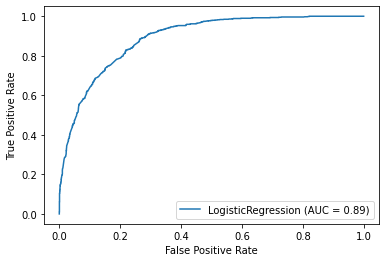

In [26]:
plot_roc_curve(regresion1,X_test,y_test,response_method='predict_proba')
plt.show()

### Matriz de confusion

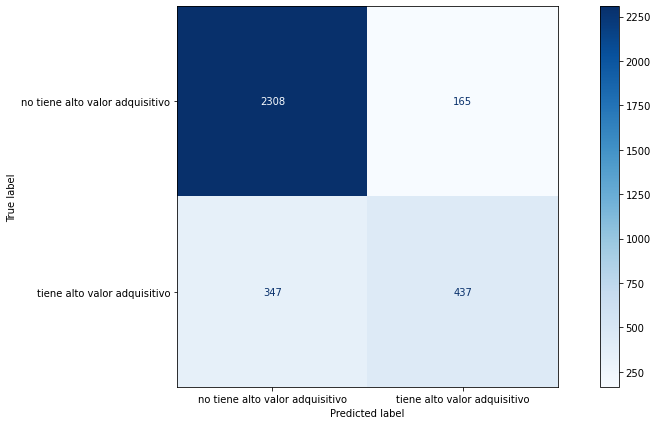

In [27]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    regresion1, X_test, y_test, cmap=plt.cm.Blues, display_labels=['no tiene alto valor adquisitivo', 'tiene alto valor adquisitivo'], ax=ax
)
plt.show()

### Accuracy

In [28]:
accuracy_score(y_test, y_pred) 

0.842800122812404

### Precision

In [29]:
precision_score(y_test, y_pred)

0.7259136212624585

### Recall

In [30]:
recall_score(y_test, y_pred)

0.5573979591836735

## Predicciones sobre el set de hold out

In [15]:
from preprocessing import prepararSetDeHoldOutRegresion

In [31]:
aux = final_df.copy()

final_df_copy = prepararSetDeHoldOutRegresion(final_df)
ho_prediction = regresion1.predict(final_df_copy)

aux['tiene_alto_valor_adquisitivo'] = ho_prediction
aux.to_csv('predicciones/regresion.csv')